## Spaceship Titanic Preprocessing

**Description:**

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!
___

# 1.Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style='darkgrid', font_scale=2)
import warnings
warnings.filterwarnings('ignore')

# 2. Loading Data

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


**Columns Description**
* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

# 3. Exploring/Viewing Data

In [3]:
r1,c1 = df_train.shape
print('The training data has {} rows and {} columns'.format(r1,c1))
r2,c2 = df_test.shape
print('The validation data has {} rows and {} columns'.format(r2,c2))

The training data has 8693 rows and 14 columns
The validation data has 4277 rows and 13 columns


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [6]:
df_test.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


### 3.B Fixing Missing Values 

In [7]:
print('MISSING VALUES IN TRAINING DATASET:')
print(df_train.isna().sum().nlargest(c1))
print('')
print('MISSING VALUES IN VALIDATION DATASET:')
print(df_test.isna().sum().nlargest(c2))

MISSING VALUES IN TRAINING DATASET:
CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
Spa             183
FoodCourt       183
Destination     182
RoomService     181
Age             179
PassengerId       0
Transported       0
dtype: int64

MISSING VALUES IN VALIDATION DATASET:
FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
VIP              93
CryoSleep        93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
PassengerId       0
dtype: int64


In [8]:
df_train.set_index('PassengerId',inplace=True)
df_test.set_index('PassengerId',inplace=True)

### 3.C Null Replacement 

In [9]:
df_train[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']] = df_train[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].fillna(0)
df_test[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']] = df_test[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].fillna(0)

df_train['Age'] =df_train['Age'].fillna(df_train['Age'].median())
df_test['Age'] =df_test['Age'].fillna(df_test['Age'].median())

df_train['VIP'] =df_train['VIP'].fillna(False)
df_test['VIP'] =df_test['VIP'].fillna(False)

df_train['HomePlanet'] =df_train['HomePlanet'].fillna('Mars')
df_test['HomePlanet'] =df_test['HomePlanet'].fillna('Mars')

df_train['Destination']=df_train['Destination'].fillna("PSO J318.5-22")
df_test['Destination']=df_test['Destination'].fillna("PSO J318.5-22")

df_train['CryoSleep'] =df_train['CryoSleep'].fillna(False)
df_test['CryoSleep'] =df_test['CryoSleep'].fillna(False)

df_train['Cabin'] =df_train['Cabin'].fillna('T/0/P')
df_test['Cabin'] =df_test['Cabin'].fillna('T/0/P')

# 4.Exploration and Visualization 

<Axes: >

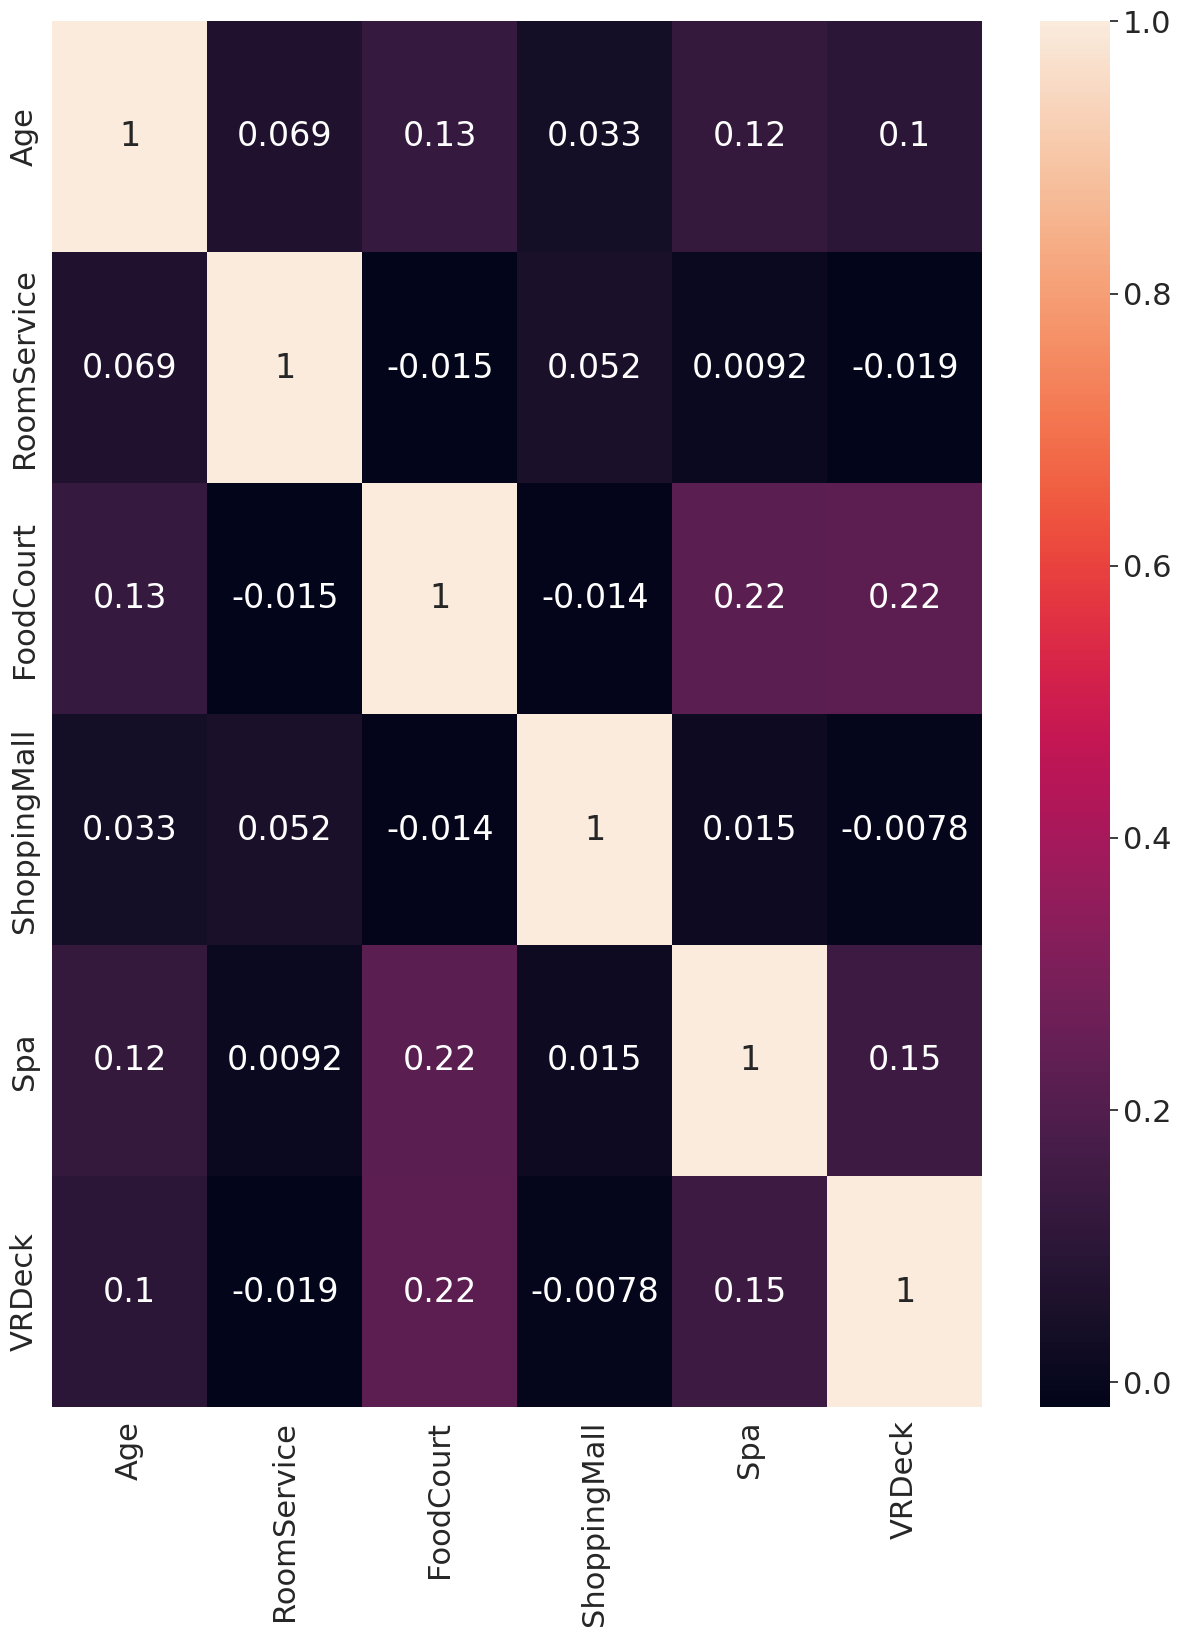

In [10]:
plt.figure(figsize=(15,18))
sns.heatmap(df_train.select_dtypes("number").corr(), annot=True)

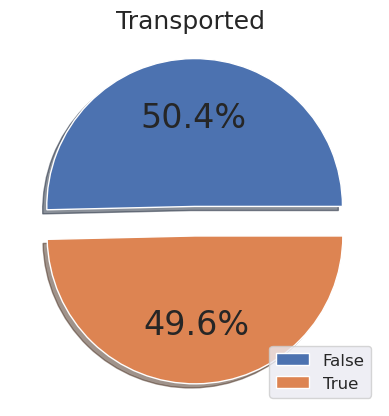

In [11]:
plt.pie(df_train.Transported.value_counts(), shadow=True, explode=[.1,.1], autopct='%.1f%%')
plt.title('Transported ', size=18)
plt.legend(['False', 'True'], loc='best', fontsize=12)
plt.show()

<Axes: xlabel='Transported', ylabel='count'>

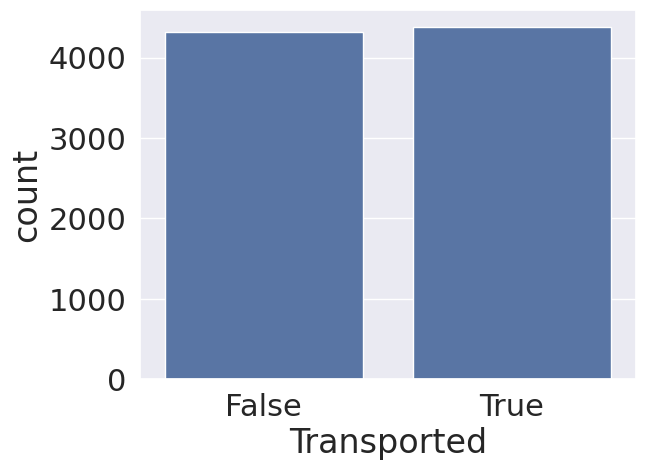

In [12]:
sns.countplot(df_train, x="Transported")

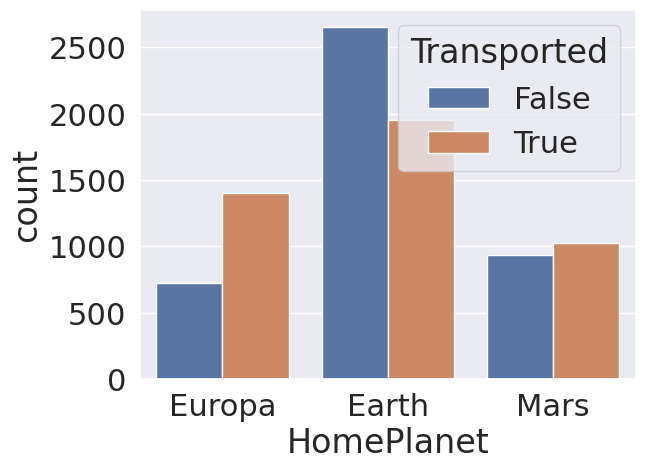

In [13]:
sns.countplot(df_train, x="HomePlanet", hue="Transported");

<Axes: xlabel='VIP', ylabel='count'>

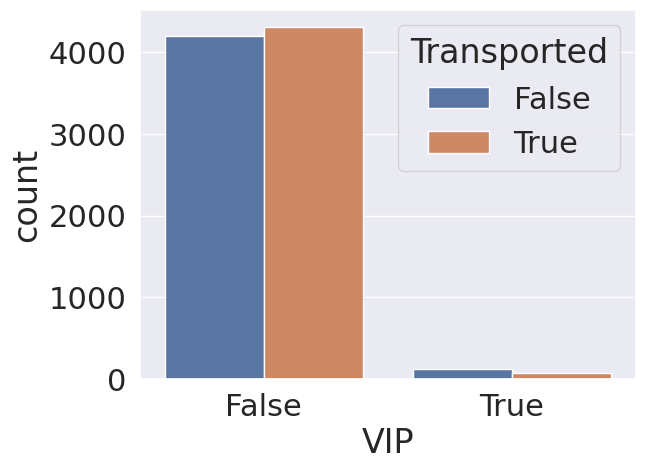

In [14]:
sns.countplot(df_train, x="VIP", hue="Transported")

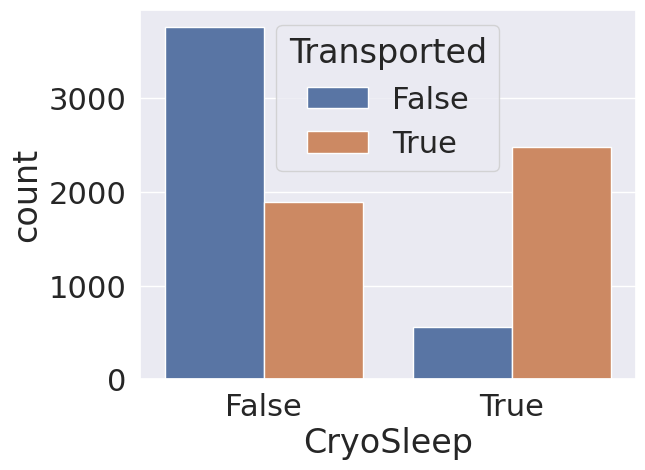

In [15]:
sns.countplot(df_train, x="CryoSleep", hue="Transported");

**The people in CryoSleep are majorly Transported**


 Do not sleep during travel alright ☠

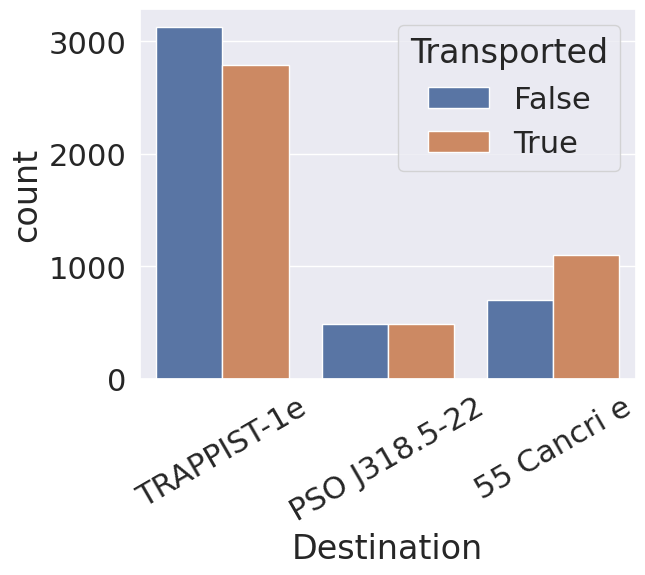

In [16]:
sns.countplot(df_train, x="Destination", hue="Transported")
plt.xticks(rotation=30);

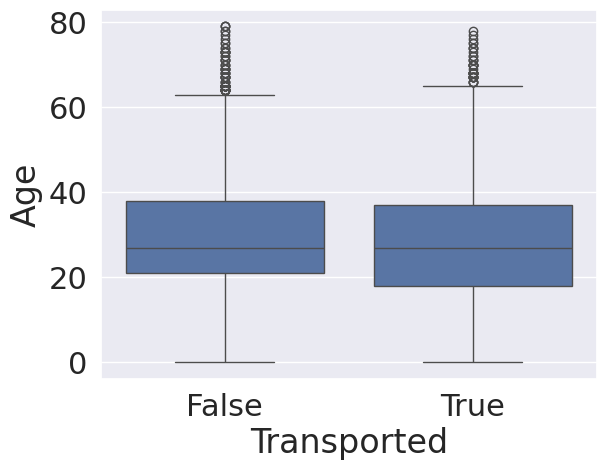

In [17]:
sns.boxplot(df_train, y="Age", x="Transported"); # Age will be divided into groups later

### 4.B Splitting Cabin Column ⚔

In [18]:
# Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
df_train[['Deck', 'Num', 'Side']] = df_train.Cabin.str.split('/',expand=True)
df_test[['Deck', 'Num', 'Side']] = df_test.Cabin.str.split('/',expand=True)

df_train['Num'] = pd.to_numeric(df_train['Num'], downcast='integer')
df_test['Num'] = pd.to_numeric(df_test['Num'], downcast='integer')

df_train['Side'] = df_train['Side'].map({'P':0,'S':1})
df_test['Side'] = df_test['Side'].map({'P':0,'S':1})

**Let's look into them**

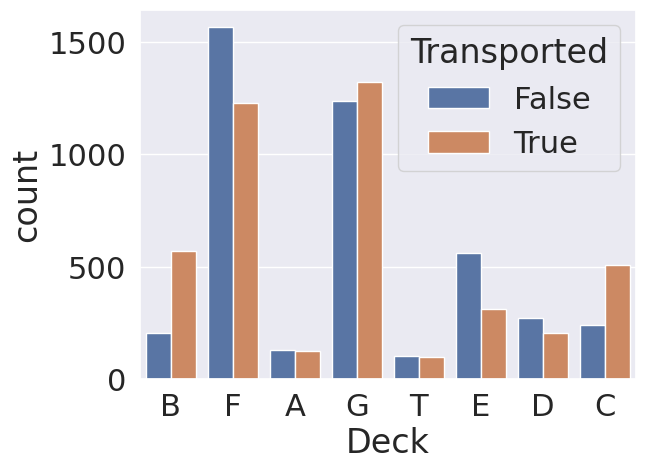

In [19]:
sns.countplot(df_train, x="Deck", hue="Transported");

<Axes: xlabel='Num', ylabel='Count'>

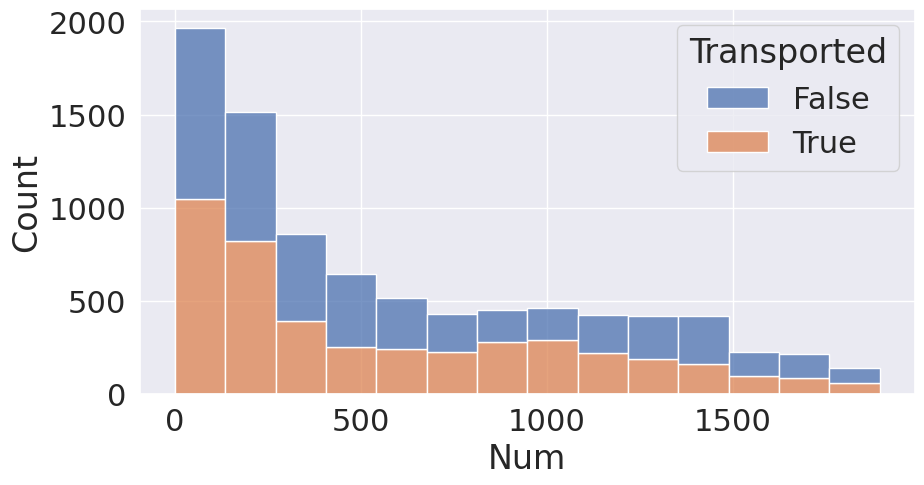

In [20]:
plt.figure(figsize=(10,5))
sns.histplot(df_train, x='Num', hue='Transported',bins=14, multiple="stack")

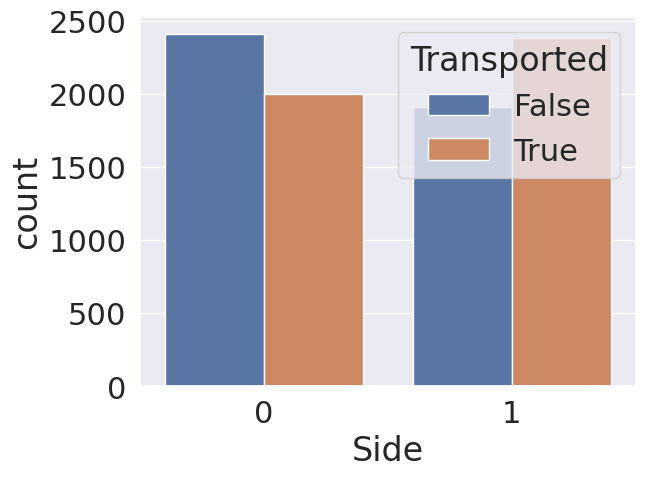

In [21]:
sns.countplot(df_train, x="Side", hue="Transported");

<Axes: xlabel='Side', ylabel='count'>

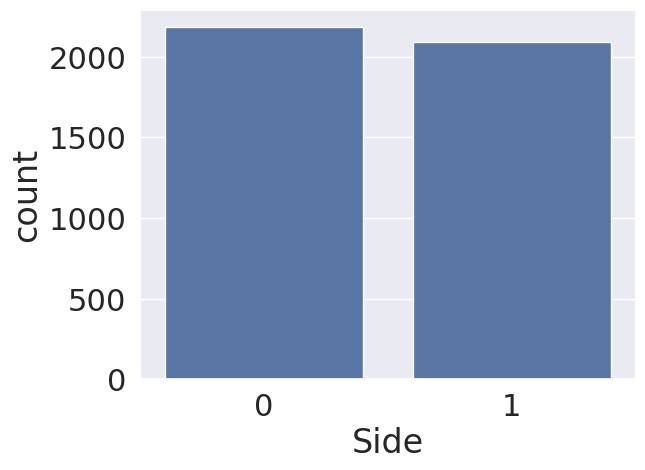

In [22]:
sns.countplot(df_test, x="Side")

# 5. Feature Engineering

In [23]:
df_train['total_spent'] = df_train['RoomService']+ df_train['FoodCourt']+ df_train['ShoppingMall']+ df_train['Spa']+ df_train['VRDeck']
df_test['total_spent'] = df_test['RoomService'] + df_test['FoodCourt'] + df_test['ShoppingMall'] + df_test['Spa'] + df_test['VRDeck']

In [24]:
df_train['AgeGroup'] = 0
for i in range(6):
    df_train.loc[(df_train.Age >= 10*i) & (df_train.Age < 10*(i + 1)), 'AgeGroup'] = i
# Same for test data
df_test['AgeGroup'] = 0
for i in range(6):
    df_test.loc[(df_test.Age >= 10*i) & (df_test.Age < 10*(i + 1)), 'AgeGroup'] = i

<Axes: xlabel='count', ylabel='AgeGroup'>

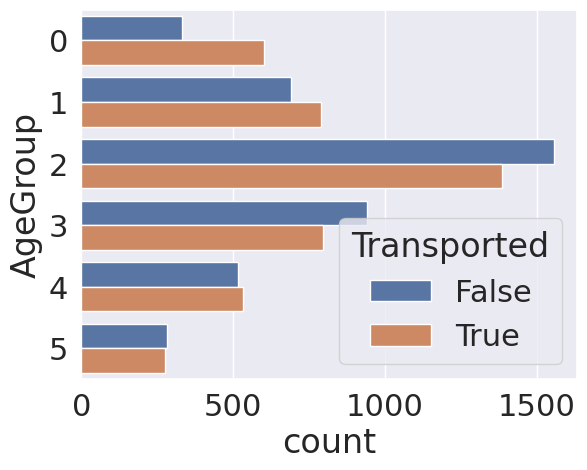

In [25]:
sns.countplot(y=df_train['AgeGroup'], hue=df_train['Transported'])

# 6. Pre processing

### 6.A Encoding

In [26]:
numeric_feats = [
    "total_spent",
    "RoomService",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
    "Age",
    "AgeGroup",
]
power_numeric_feats = [
    "Num",
]
categorical_feats = [
    "HomePlanet",
    "Destination",
    "Deck",
]
binary_feats = [
    "VIP",
    "CryoSleep",
    "Side",    
]
drop_feats = [
    "Cabin",
    "Name",
]
passthrough_feats = [
    "Transported",
]

In [27]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler, PowerTransformer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline

ct = make_column_transformer(
    (RobustScaler(), numeric_feats),
    (
        make_pipeline(
            PowerTransformer(),
            RobustScaler()
        ),
        power_numeric_feats
    ),
    (OneHotEncoder(), categorical_feats),
    (OrdinalEncoder(), binary_feats),
    ("drop", drop_feats),
    ("passthrough", passthrough_feats),
)

In [28]:
ct

,transformers,"[('robustscaler', ...), ('pipeline', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,with_centering,True
,with_scaling,True
,quantile_range,"(25.0, ...)"


In [29]:
df_train = ct.fit_transform(df_train)
# df_test_trans = ct.transform(df_test)

In [30]:
column_names = ct.get_feature_names_out()
clean_names = [name.split("__", 1)[-1] for name in column_names]

df_train = pd.DataFrame(df_train, columns=clean_names)

In [31]:
pd.DataFrame(df_train).head()

,total_spent,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Age,AgeGroup,Num,HomePlanet_Earth,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,VIP,CryoSleep,Side,Transported
0,-0.496877,0.000000,0.000000,0.000000,0.000000,0.000,0.705882,0.5,-1.334264,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.013879,2.658537,0.147541,1.136364,10.358491,1.100,-0.176471,0.0,-1.334264,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,6.708536,1.048780,58.622951,0.000000,126.698113,1.225,1.823529,1.5,-1.334264,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,3.095073,0.000000,21.032787,16.863636,62.811321,4.825,0.352941,0.5,-1.334264,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.260236,7.390244,1.147541,6.863636,10.660377,0.050,-0.647059,-0.5,-1.284269,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


### 6.B Dropping Columns

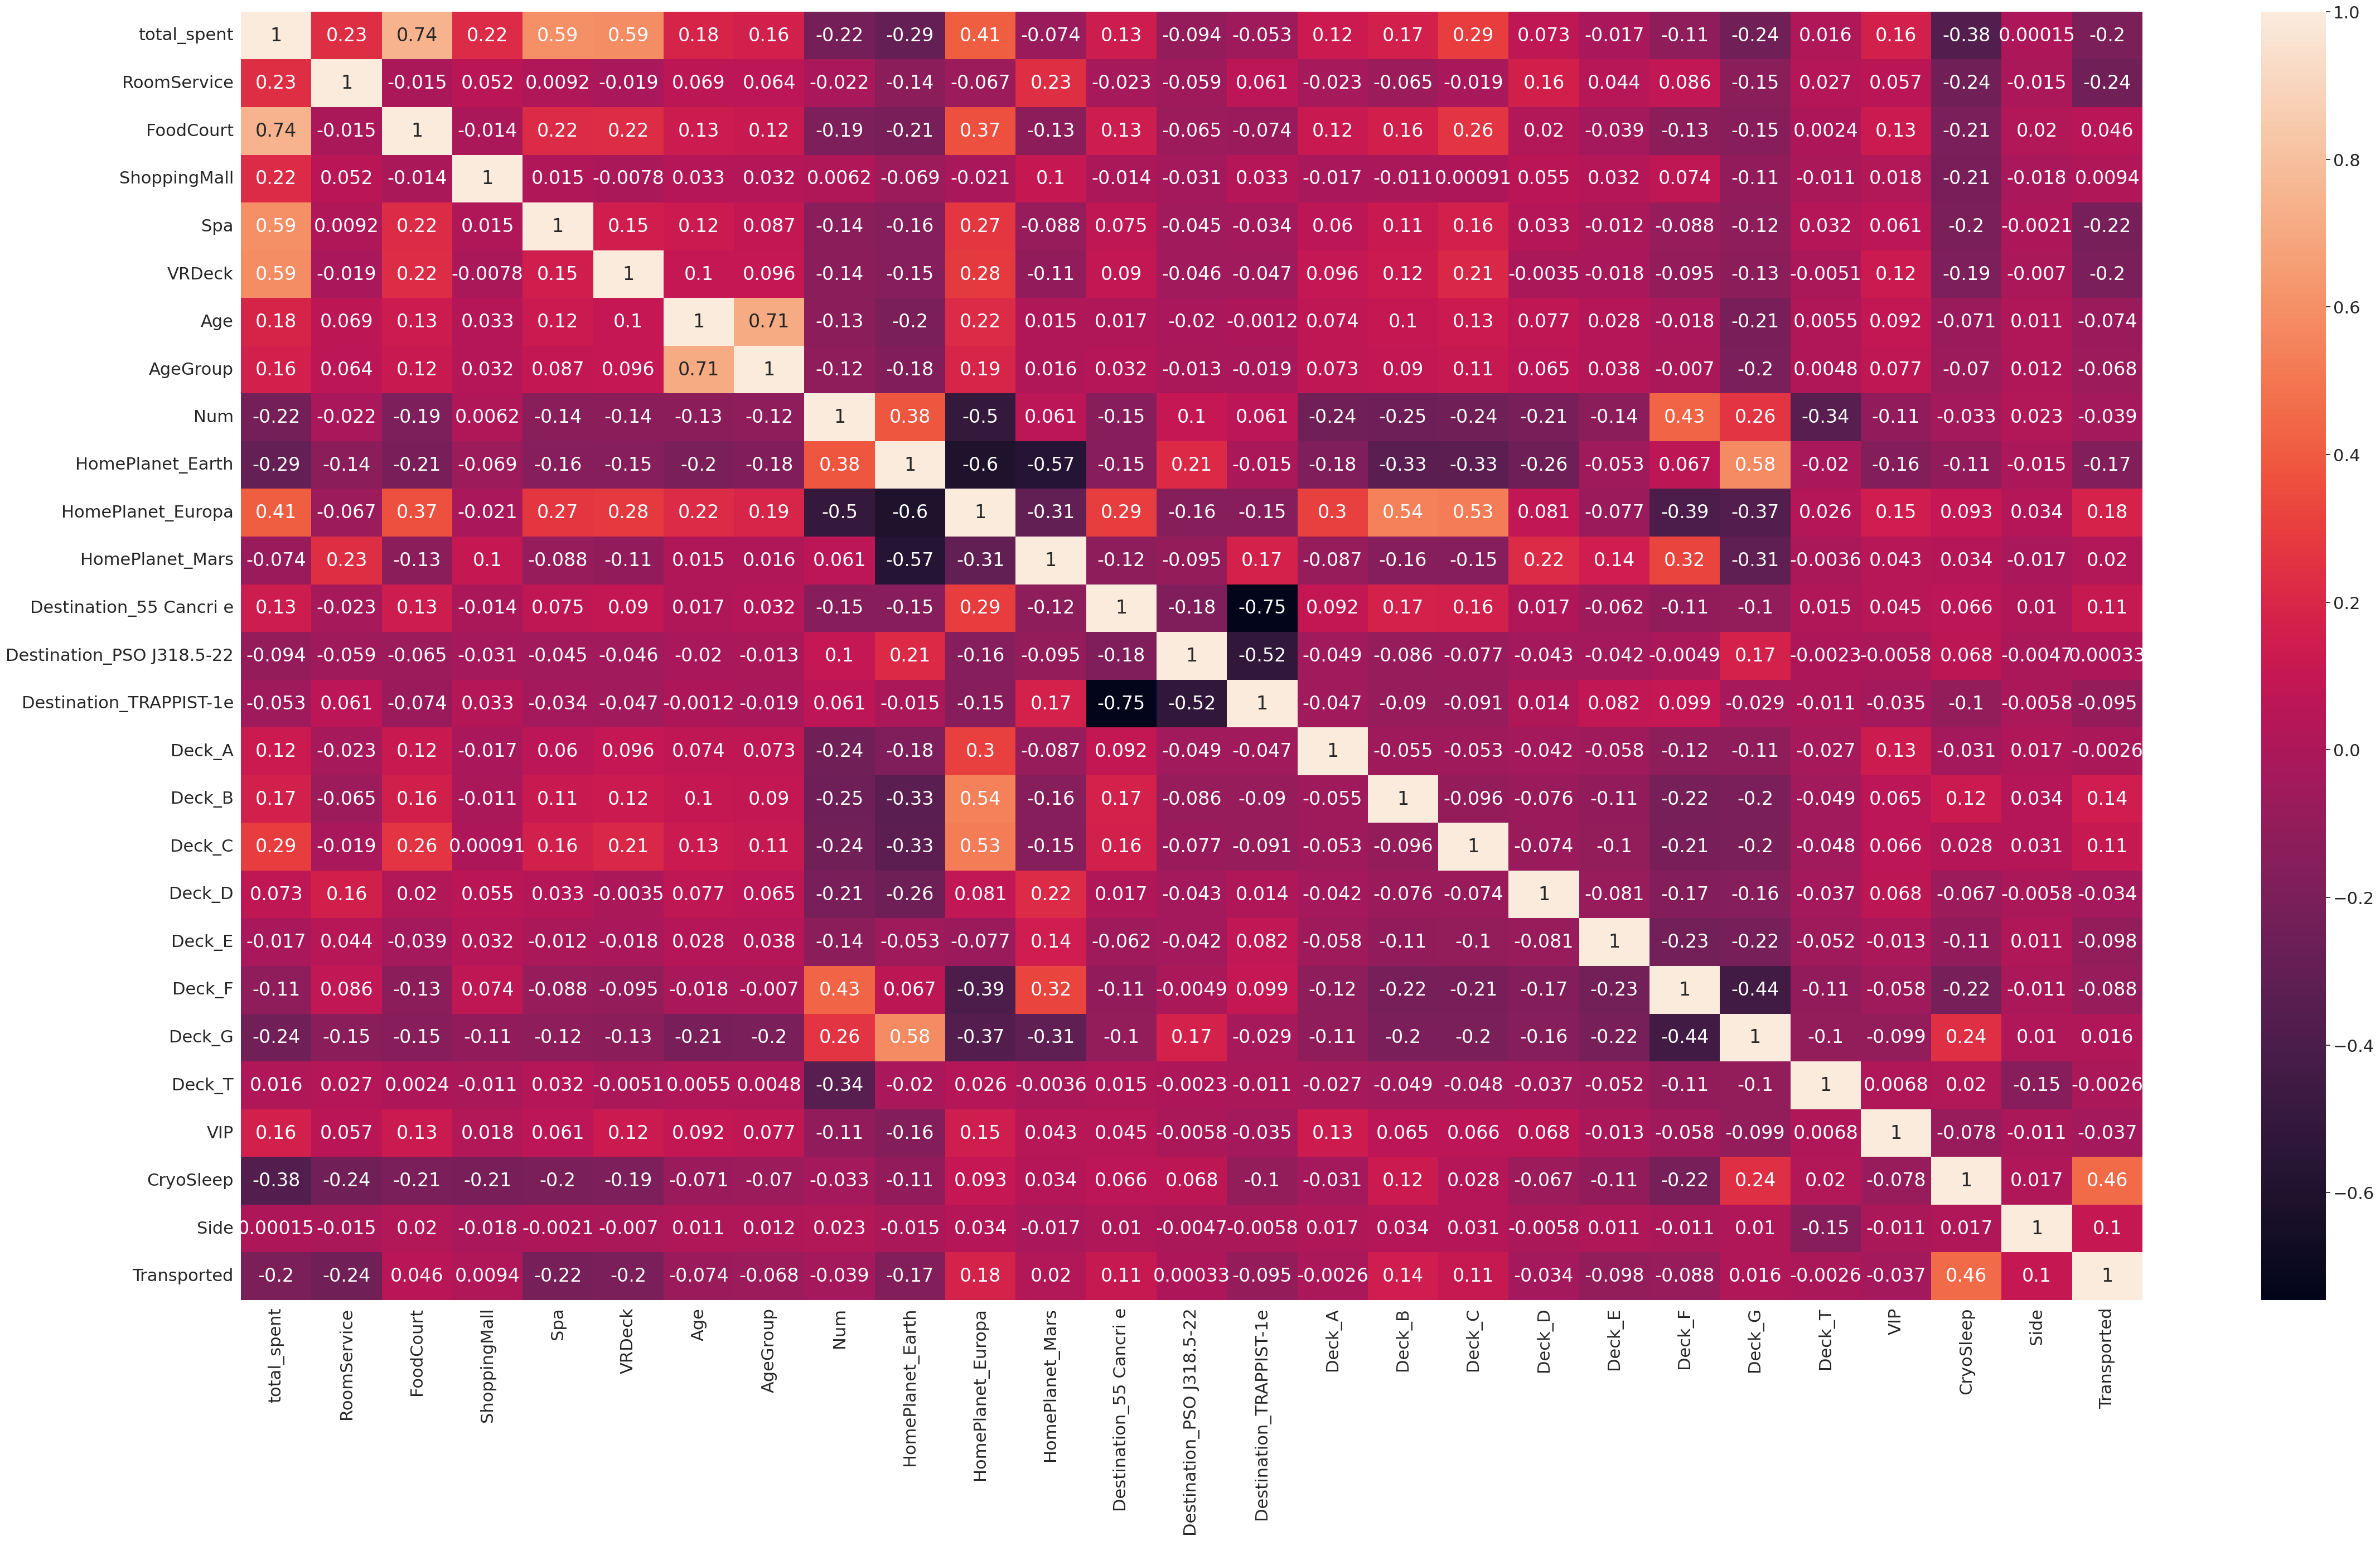

In [32]:
plt.figure(figsize=(55,30))
sns.heatmap(df_train.corr(), annot=True);

In [33]:
df_train['Transported']=df_train['Transported'].replace({True:1,False:0})

In [34]:
X = df_train.drop('Transported', axis=1)
y = df_train['Transported']

In [35]:
X.columns.tolist()

['total_spent',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Age',
 'AgeGroup',
 'Num',
 'HomePlanet_Earth',
 'HomePlanet_Europa',
 'HomePlanet_Mars',
 'Destination_55 Cancri e',
 'Destination_PSO J318.5-22',
 'Destination_TRAPPIST-1e',
 'Deck_A',
 'Deck_B',
 'Deck_C',
 'Deck_D',
 'Deck_E',
 'Deck_F',
 'Deck_G',
 'Deck_T',
 'VIP',
 'CryoSleep',
 'Side']